let's load the dependencies

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score
import os
from tqdm import tqdm
import seaborn as sns
import mne
from scipy import signal
import numpy as np
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [3]:
def preprocess(data): # Pass sampling rate as an argument
    # median filter to remove artifacts
    # data = signal.medfilt(data, kernel_size=3) # Uncomment if needed

    # --- High-Pass Filter ---
    hpf_cutoff = 0.1  # Hz - Recommended for ERPs to remove slow drift
    hpf_order = 4     # Filter order (can be same or different from LPF)

    # Design Butterworth HPF
    # Note: fs/2 is the Nyquist frequency
    b_high, a_high = signal.butter(hpf_order, hpf_cutoff / 100, btype='high')

    # Apply HPF using zero-phase filtering
    # Apply along the time axis (assuming channels x time or trials x channels x time)
    data_hpf = signal.filtfilt(b_high, a_high, data, axis=-1)

    # --- Low-Pass Filter ---
    lpf_cutoff = 40.0  # Hz - Typical for ERPs
    lpf_order = 4      # Filter order

    # Design Butterworth LPF
    b_low, a_low = signal.butter(lpf_order, lpf_cutoff / 100, btype='low')

    # Apply LPF using zero-phase filtering to the high-passed data
    filtered_data = signal.filtfilt(b_low, a_low, data_hpf, axis=-1)

    return filtered_data

let's read the csv files, filter the time series and epoch them

In [4]:
channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
    'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
    'POz', 'P08', 'O1', 'O2']

all_epochs = []
all_labels = pd.read_csv('TrainLabels.csv').Prediction.values #

for filename in tqdm(os.listdir('train')): # Loop through all sessions
    session_data = pd.read_csv('train/' + filename) # Load one session
    for channel in channels:
        session_data[channel] = preprocess(session_data[channel].values) # filter each EEG channel
    
    # session_data['EOG'] = preprocess(session_data['EOG'].values) # filter the EOG time series

    session_feedback_ids = session_data[session_data['FeedBackEvent'] == 1].index # identify the event markers
    session_epochs = [] # list to store all epochs in the session
    for idx in session_feedback_ids:
        epoch = session_data.loc[idx-40:idx + 199] # 200ms before and 1000ms after the event
        baseline = session_data.loc[idx-40:idx, channels].values.mean(axis=0) # calculate the baseline
        epoch.loc[:, channels] -= baseline # baseline correction
        session_epochs.append(epoch) # append the epoch to the list of all epochs in the session
    
    all_epochs.extend(session_epochs) # add the epochs to the list of all epochs

100%|██████████| 80/80 [06:47<00:00,  5.09s/it]


let's now collapse the epochs into subsequent 25ms time windows and calculate the ROC score for each window and channel

In [5]:
channel_to_roc = {}

for channel in tqdm(channels):
    channel_data = [epoch[channel].values for epoch in all_epochs]
    channel_data = np.array(channel_data)
    rocs = []
    # for timepoint in range(240):
    #     timepoint_data = channel_data[:, timepoint]
    #     rocs.append(roc_auc_score(all_labels, timepoint_data))
    
    for time_point in range(0, 240, 5):
        time_window_data = channel_data[:, time_point:time_point+5].mean(axis=1) # average voltage over 5 time points (25ms)
        rocs.append(roc_auc_score(all_labels, time_window_data)) # calculate AUC for the time window
    
    channel_to_roc[channel] = rocs

100%|██████████| 56/56 [00:36<00:00,  1.54it/s]


display the ROC scores as a heatmap

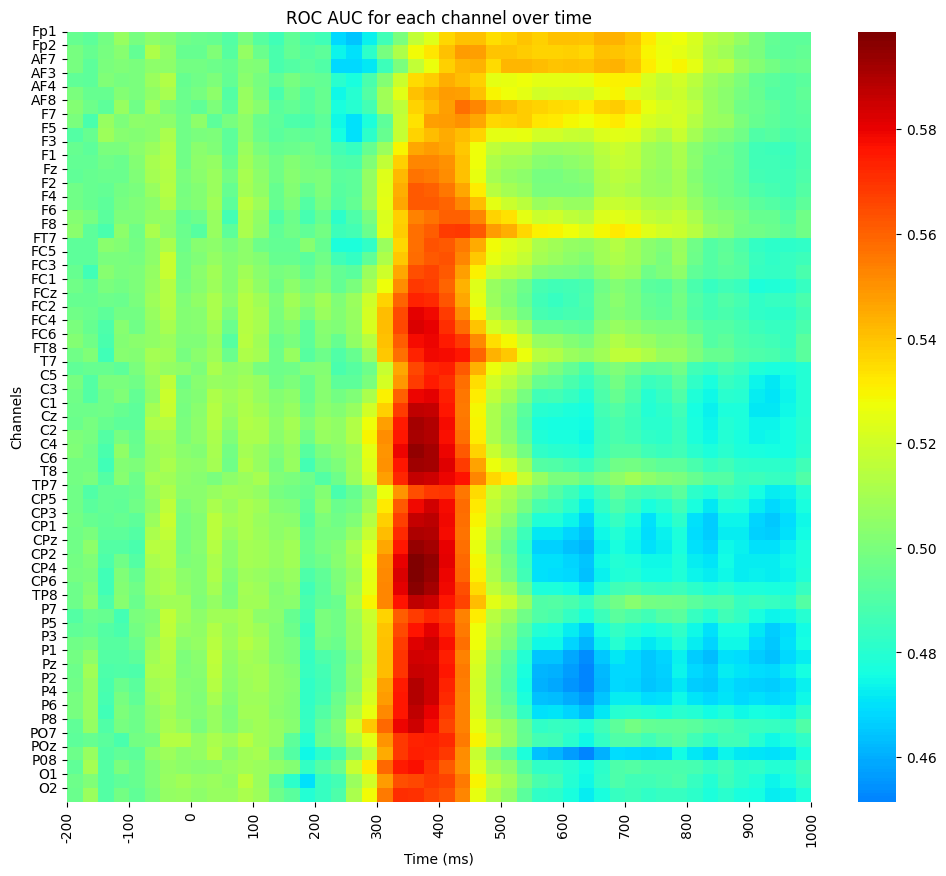

In [13]:
arr = np.array([channel_to_roc[channel] for channel in channels])
plt.figure(figsize=(12, 10))
sns.heatmap(arr, cmap='jet', center=0.5)
plt.xticks(np.arange(0, 52, 4), np.arange(-200, 1100, 100), rotation=90)
plt.yticks(np.arange(0, len(channels)), channels, rotation=0)
plt.xlabel('Time (ms)')
plt.ylabel('Channels')
plt.title('ROC AUC for each channel over time')
plt.show()

evidently, among others, the interval around 300-450 ms looks interesting.

Let's look at the topographies of the ROC scores for each of the time windows

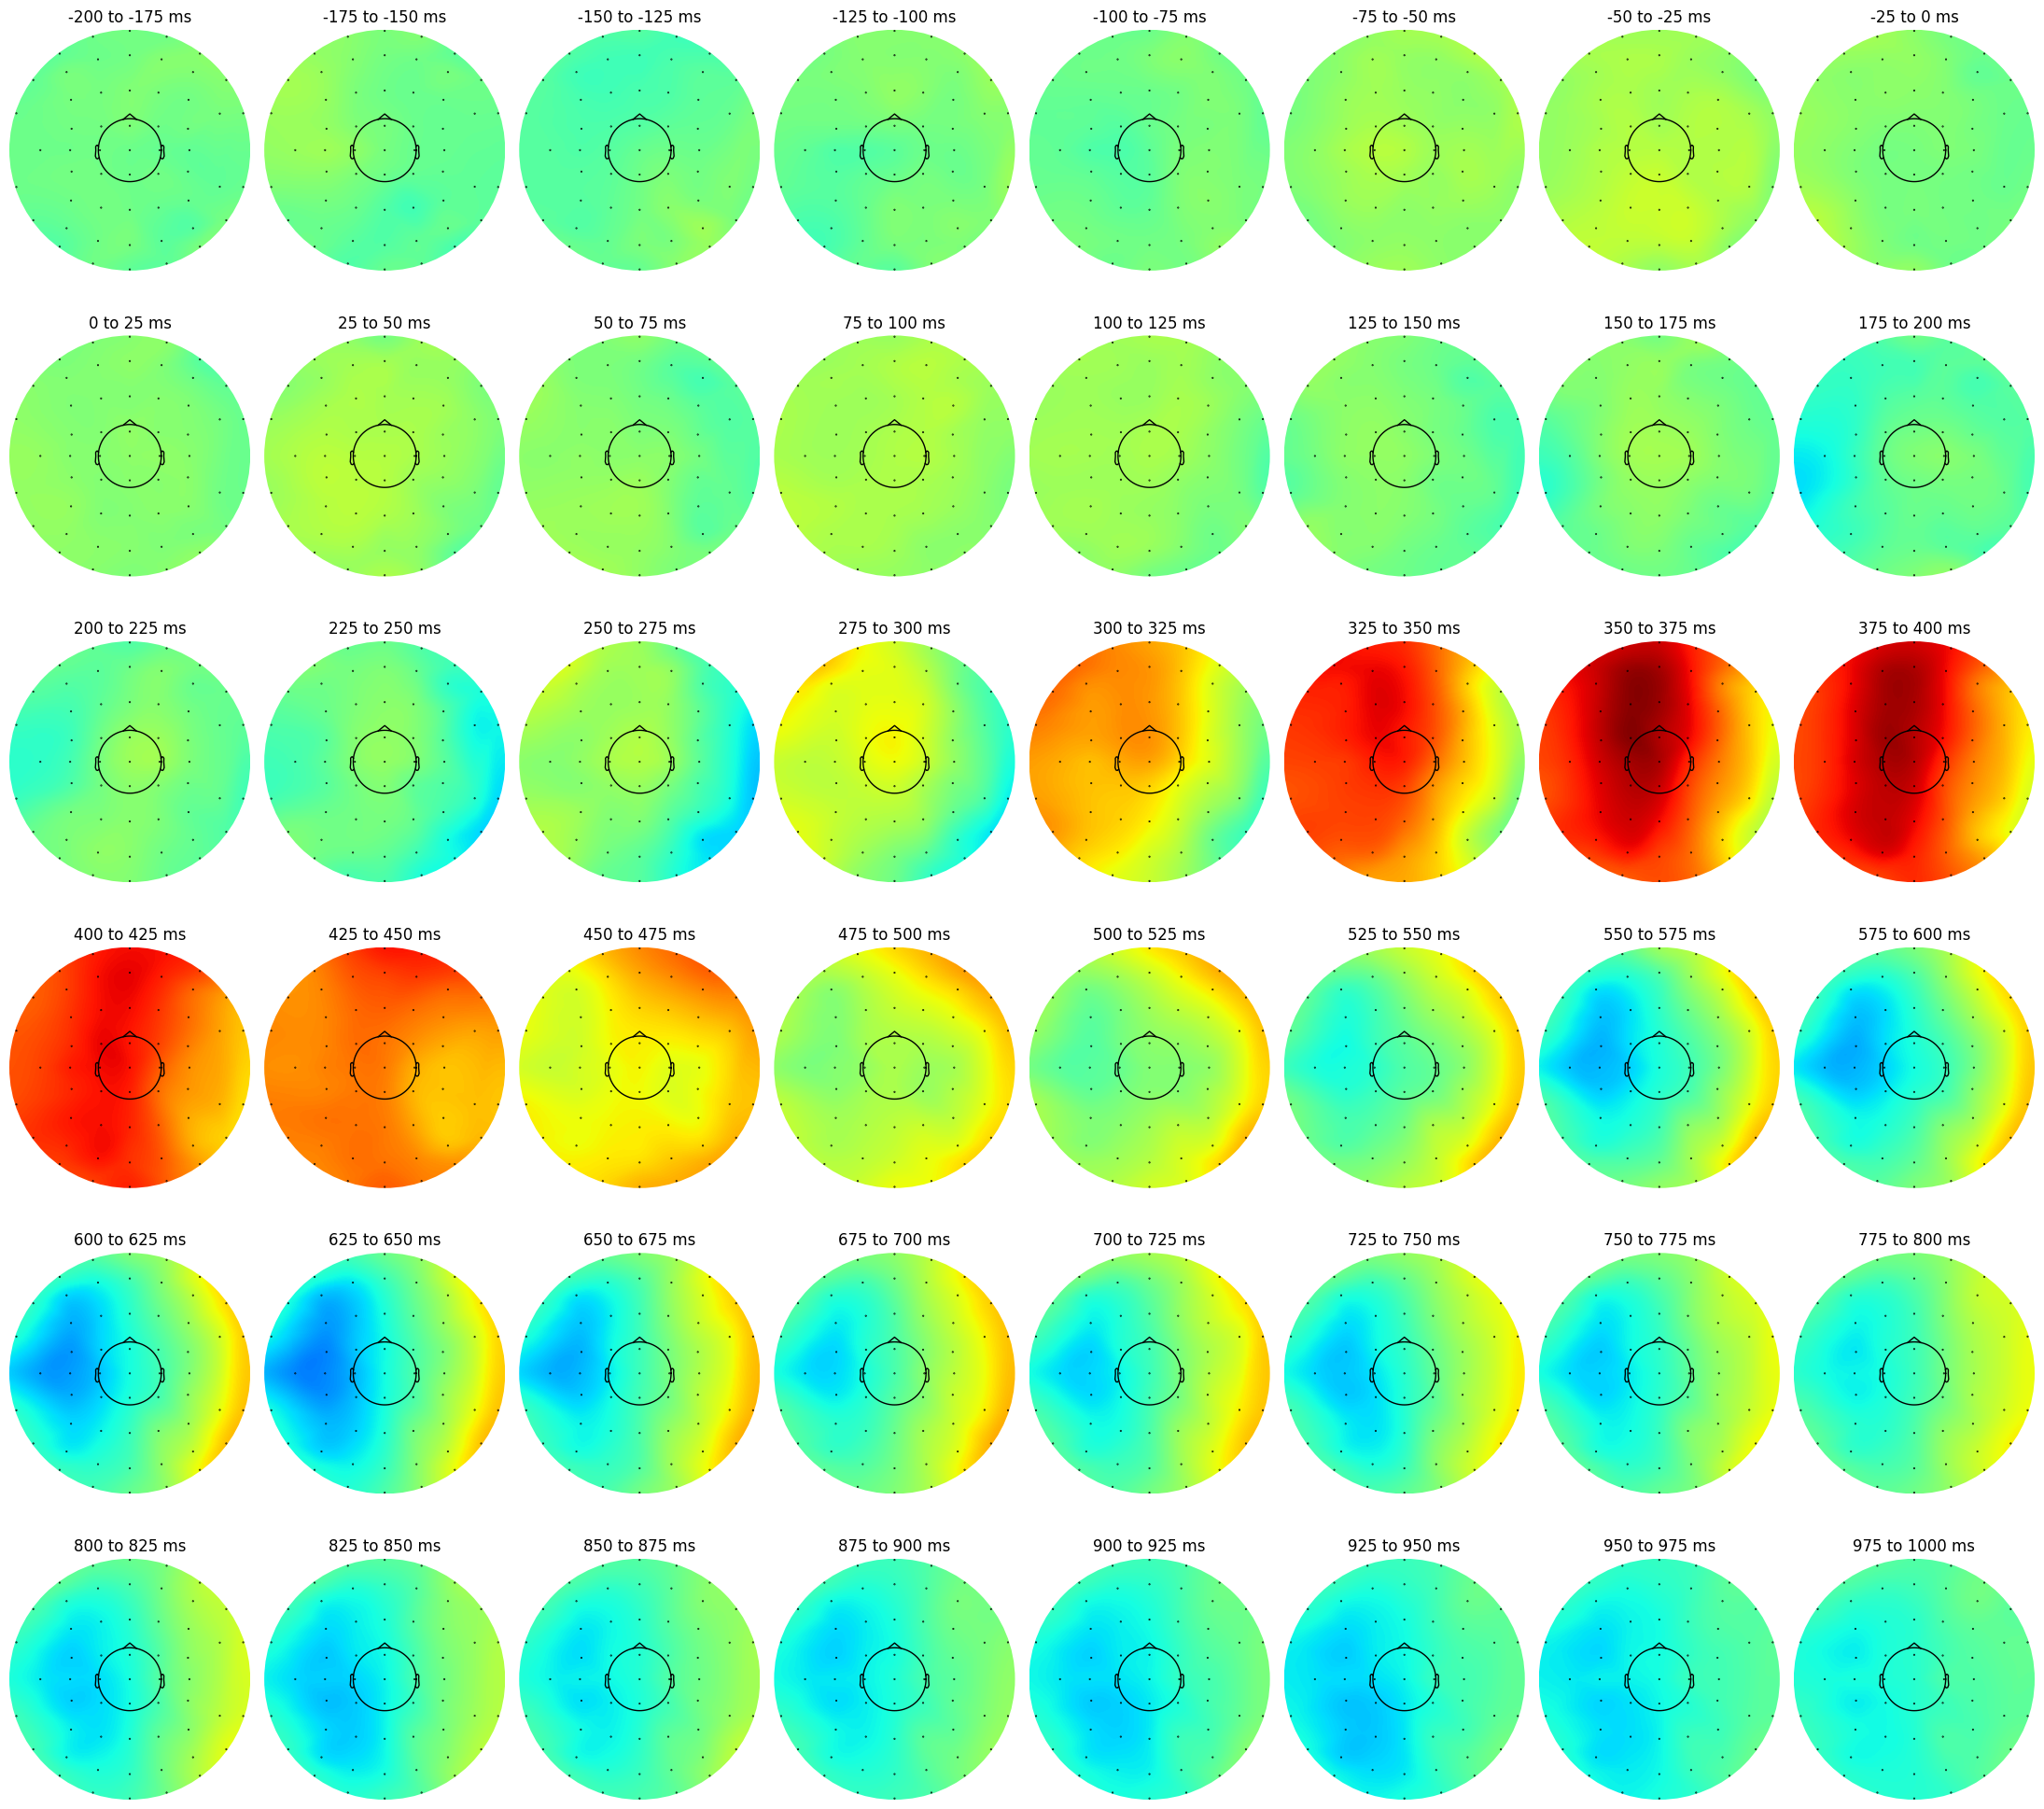

In [29]:
# Load CSV
df = pd.read_csv("ChannelsLocation.csv")

# Convert spherical (Radius, Phi) -> Cartesian (X, Y, Z)
df["Phi"] = np.deg2rad(df["Phi"])  # Convert degrees to radians
df["X"] = df["Radius"] * np.cos(df["Phi"])
df["Y"] = df["Radius"] * np.sin(df["Phi"])
df["Z"] = np.zeros(len(df))  # Assume all electrodes lie on a 2D plane

# Create Montage
ch_pos = {row["Labels"]: [row["X"], row["Y"], row["Z"]] for _, row in df.iterrows()}
montage = mne.channels.make_dig_montage(ch_pos, coord_frame="head")

# Create info object
ch_names = list(df["Labels"])
info = mne.create_info(ch_names, sfreq=200, ch_types="eeg")
info.set_montage(montage)

# Example: Plot Topomap with Random Data
f, ax = plt.subplots(6, 8, figsize=(22, 20))
ax = ax.ravel()

for i in range(0, 48):
    ax[i].set_title(f"{(i - 8)*25} to {(i - 7)*25} ms")
    mne.viz.plot_topomap(arr[:, i], info, size=3, cmap="jet", vlim=(0.4, 0.6), 
                        show=False, outlines="head", axes=ax[i], contours=False)

plt.tight_layout()
plt.show()


Based on the topographies, we can proceed with the intervals from 300 ms to 475 ms.

## PCA

We have identified the most promising time intervals for analysis.

We can treat the average voltage in each channel for each time interval as a separate feature.
This amounts to _ features.

Let's run PCA on them.

In [68]:
X = []
features = [f"{channel}_{time_point * 5 - 200}" for channel in channels for time_point in range(100, 135, 5)]

for channel in tqdm(channels):
    channel_data = [epoch[channel].values for epoch in all_epochs]
    channel_data = np.array(channel_data)
    for time_point in range(80, 115, 5):
        time_window_data = channel_data[:, time_point:time_point+5].mean(axis=1) # average voltage over 5 time points (25ms)
        X.append(time_window_data) # append the time window data to the list of all epochs in the session

X = np.array(X).T # Transpose to get shape (n_samples, n_features)
dataset = pd.DataFrame(X, columns=features) # Convert to DataFrame for easier handling
dataset['Label'] = all_labels # Add labels to the dataset

100%|██████████| 56/56 [00:01<00:00, 34.70it/s]


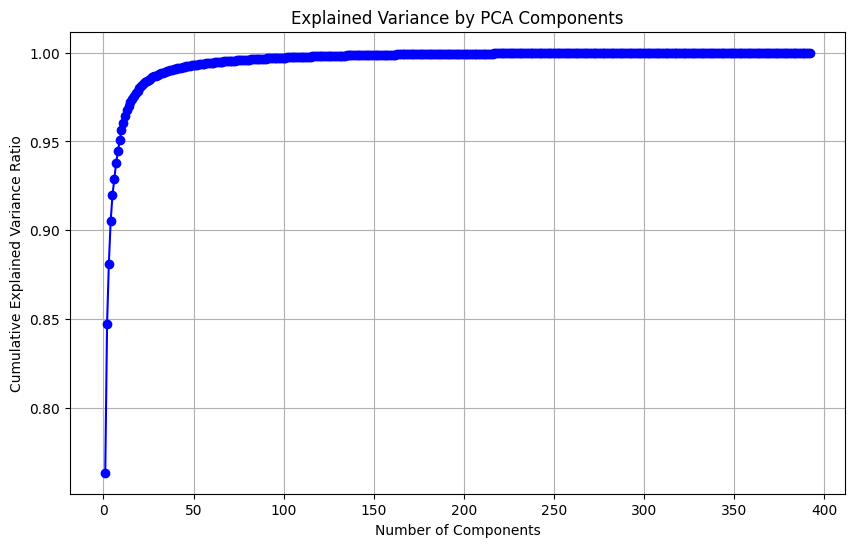

Number of components to explain variance:
80.0% variance: 2 components
85.0% variance: 3 components
90.0% variance: 4 components
95.0% variance: 9 components
97.5% variance: 17 components


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Assuming the dataset is loaded as 'data'
# Split features and target
X = dataset.drop(columns=['Label']).values  # Features
y = dataset['Label'].values  # Target variable

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

# Determine number of components for different variance thresholds
variance_thresholds = [0.80, 0.85, 0.90, 0.95, 0.975]
components_for_thresholds = {
    threshold: np.argmax(cumulative_variance_ratio >= threshold) + 1 
    for threshold in variance_thresholds
}

print("Number of components to explain variance:")
for threshold, num_components in components_for_thresholds.items():
    print(f"{threshold*100}% variance: {num_components} components")

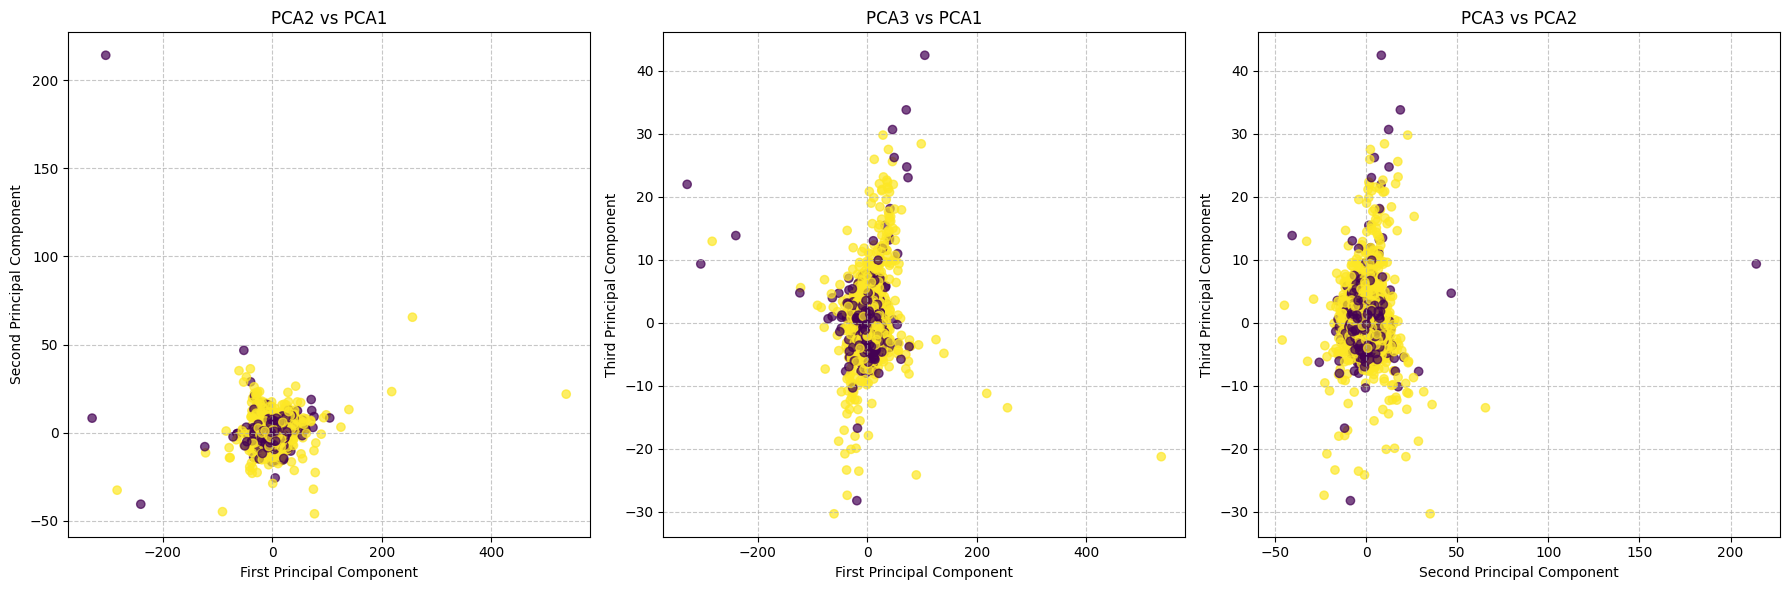

Variance explained by first 3 principal components:
PC1: 0.7633 (76.33%)
PC2: 0.0838 (8.38%)
PC3: 0.0340 (3.40%)
Total: 0.8811 (88.11%)


In [65]:
# Create a figure with 3 subplots for PCA visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot PCA2 vs PCA1
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title('PCA2 vs PCA1')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot PCA3 vs PCA1
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 2], c=y, cmap='viridis', alpha=0.7)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Third Principal Component')
axes[1].set_title('PCA3 vs PCA1')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Plot PCA3 vs PCA2
scatter3 = axes[2].scatter(X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', alpha=0.7)
axes[2].set_xlabel('Second Principal Component')
axes[2].set_ylabel('Third Principal Component')
axes[2].set_title('PCA3 vs PCA2')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Display variance explained by the first three components
print(f"Variance explained by first 3 principal components:")
print(f"PC1: {explained_variance_ratio[0]:.4f} ({explained_variance_ratio[0]*100:.2f}%)")
print(f"PC2: {explained_variance_ratio[1]:.4f} ({explained_variance_ratio[1]*100:.2f}%)")
print(f"PC3: {explained_variance_ratio[2]:.4f} ({explained_variance_ratio[2]*100:.2f}%)")
print(f"Total: {sum(explained_variance_ratio[:3]):.4f} ({sum(explained_variance_ratio[:3])*100:.2f}%)")

## LDA

The PCA features allow us to fit an LDA model on this dataset

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.31      0.40       303
           1       0.77      0.89      0.83       785

    accuracy                           0.73      1088
   macro avg       0.65      0.60      0.61      1088
weighted avg       0.71      0.73      0.71      1088



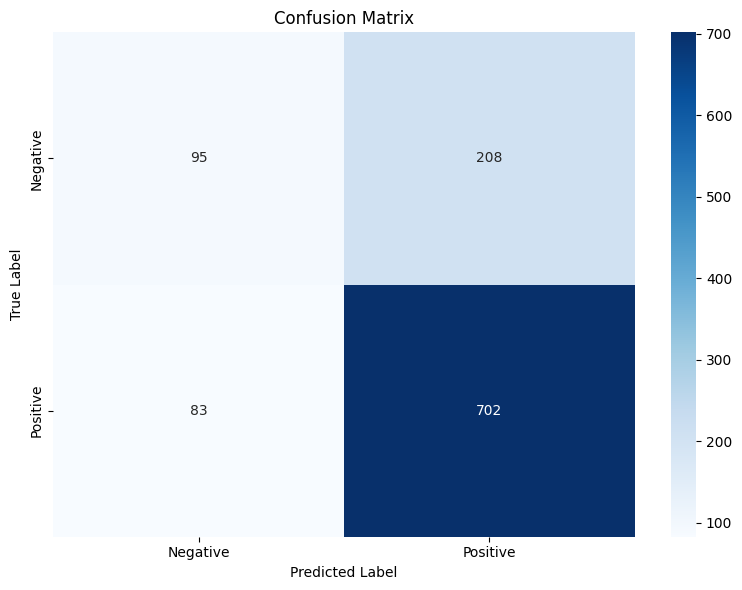

ROC AUC Score: 0.6039


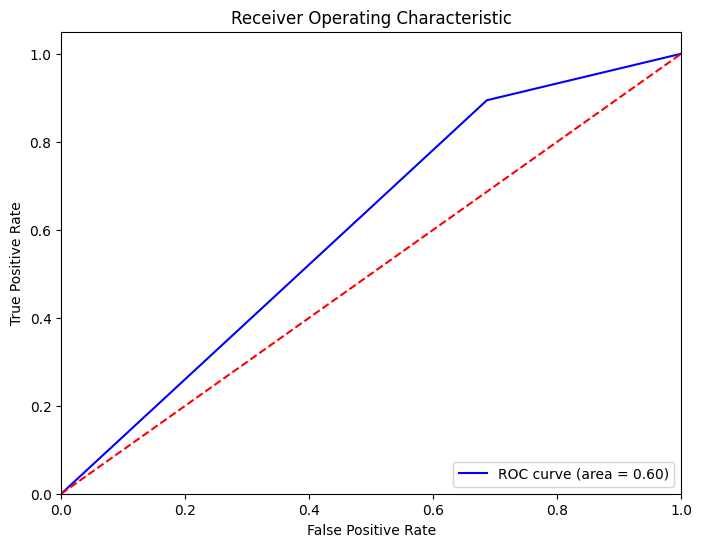

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# using all features for LDA:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create an LDA model
lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

# Calculate metrics

conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix display
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC AUC for LDA:
from sklearn.metrics import roc_auc_score, roc_curve

roc_auc_score_value = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc_score_value:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score_value)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
